## NK Model

In [42]:
#import necessary packages
import numpy as np
import random as rd
import matplotlib.pyplot as plot
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
#set values of N and K here
N = 3
K = 2
B = 2**(K+1) #=total fitness contributions per gene (= columns in fitness matrix)
M = 4 #total number of individuals (= # average genomes or groups)

Creating 3 matrices with versions of NK model:
- NK - without neutrality
- NKp - with neutrality (probabilistic)
- NKq - with neutrality (quantised)

In [43]:
#create fitness matrix without neutrality: simply array of shape (N,X), filled with random decimals 
fmk = np.random.rand(N, B)

#NKp: reduce fraction of fitness contributions in fm to 0
# p = probability a value is set to 0
# Verel et al.: p ∈ {0.5, 0.8, 0.9}; Geard et al. p = ((N-1)/N) -  but explore options
p = ((N-1)/N) #is it? :)
fmp = np.where(np.random.rand(*fmk.shape) < p, 0, fmk) 
#takes array of shape fmk and filled with random decimals, and if decimals in that array are below p, corresponding decimal from fmk becomes 0 in new array fmp

#NKq: fitness contribution < 0.5 == 0, > 0.5 == 1
# q = number of quantiles (or levels). q > 1 - i.e. setting q as 2 will divide the decimals in two groups of integers: 0 and 1. 
# Verel et al. (2011) - q ∈ {2, 4, 10} - but explore options - Higher q -> lower neutrality 
q = 4
fmq = np.digitize(fmk, bins=np.linspace(0, 1, q+1), right=True) - 1
#decimals from fmk split into q bins numbered from 0 to q-1, based on their decimal value, new values in array fmq

Choose neutrality version:

In [44]:
#replace fmk in following line with "fmp" or "fmq" when adding probabilistic or quantized neutrality to model
#note: maybe for final code: one function to create model versions and choose 
##als het lukt?
fm = np.copy(fmk) 
print(fm)

[[0.66902076 0.74266734 0.9653727  0.57714323 0.13292137 0.96102764
  0.90611867 0.45674257]
 [0.61011223 0.8430859  0.8808638  0.71131903 0.87025235 0.5999801
  0.45702017 0.62528107]
 [0.04120203 0.16473445 0.03466269 0.44273548 0.00720694 0.14271806
  0.79329069 0.71081744]]


Creating corresponding epistasis matrix

In [45]:
#creates "identity matrix": array with genome id's
im0 = np.arange(0, B, 1)
im1 = im0[np.newaxis, :]
im = np.repeat(im1, N, axis=0)
print("identity matrix")
print(im)

#Binary representation of im (just for visualisation)
imbin = np.vectorize(np.binary_repr)(im, 4) #increase 4 to to 8/16/32 with larger N 
print("binary identity matrix")
print(imbin)
#maybe useful later

identity matrix
[[0 1 2 3 4 5 6 7]
 [0 1 2 3 4 5 6 7]
 [0 1 2 3 4 5 6 7]]
binary identity matrix
[['0000' '0001' '0010' '0011' '0100' '0101' '0110' '0111']
 ['0000' '0001' '0010' '0011' '0100' '0101' '0110' '0111']
 ['0000' '0001' '0010' '0011' '0100' '0101' '0110' '0111']]


In [46]:
#important: in this version each gene influenced by K others, but genes 
# can influence >2 other genes, so some are (way) more influential than others
# print a few times to see
val = list(range(0, N))
em1 = []

for row in range(N):
    rd.shuffle(val)  #shuffle the values
    em1.append(val[:K] + [row])  #epistatic genes as pair and row number added

em1_inc = np.array(em1) #with own gene referenced
print(em1_inc)

em1 = (em1_inc[:, :-1]) #without own gene referenced
##nog steeds dubbele waardes in rij fix!

[[2 1 0]
 [0 2 1]
 [1 0 2]]


In [47]:
#important: in this version each gene influenced by K others, and influences K others, so all equally influential
#help from stackoverflow user
#generates tree (nested dictionary) of all possible permutations of list of numbers except for a specified level
def generate_all_moved_perm_tree(level, nums):
    if len(nums) == 1:
        if level == nums[0]:
            return None
        else:
            return {nums[0]: {}}
    allowed_n = list(nums)
    if level in allowed_n:
        allowed_n.remove(level)
    result = {}
    for n in allowed_n:
        sublevel_n = list(nums)
        if n in sublevel_n:
            sublevel_n.remove(n)
        subtree = generate_all_moved_perm_tree(level + 1, sublevel_n)
        if subtree is not None:
            result[n] = subtree
    if len(result) == 0:
        return None
    return result

#picks permutation of numbers from previously generated tree, with each number selected only once
def pick_all_moved_perm(all_moved_perm_tree, picked=None):
    if picked is None:
        picked = set()
    allowed_ns = set(all_moved_perm_tree.keys()) - picked
    if not allowed_ns:
        return []
    n = rd.choice(list(allowed_ns))
    picked.add(n)
    l = [n]
    sub_tree = all_moved_perm_tree[n]
    if len(sub_tree) > 0:
        l.extend(pick_all_moved_perm(sub_tree, picked))
    return l

#generates array of unique pairs of numbers, with no number repeated in row 
def generate_unique_r(t, num_rows):
    result = []
    for _ in range(num_rows):
        row = list(zip(pick_all_moved_perm(t), pick_all_moved_perm(t)))
        while any(x[0] == x[1] for x in row):
            row = list(zip(pick_all_moved_perm(t), pick_all_moved_perm(t)))
        result.extend(row)
    return np.array(result[:num_rows])

t = generate_all_moved_perm_tree(1, range(1, N+1))
em2 = generate_unique_r(t, N)

#for comparison: (can be removed)
print("Epistasis matrix with repetition")
print(em1_inc)
print("Epistasis matrix without repetition")
em2 -= 1 #without own gene referenced

em2_inc = np.hstack((em2, np.arange(em2.shape[0]).reshape(-1, 1)))
print(em2_inc) #with own gene referenced 

##er moet een manier zijn om dit makkelijker te doen???

Epistasis matrix with repetition
[[2 1 0]
 [0 2 1]
 [1 0 2]]
Epistasis matrix without repetition
[[2 1 0]
 [0 2 1]
 [1 0 2]]


Calculating coefficients ai0 to aij

In [48]:
def calc_a(K, fm): 
    a_coef = []
    for r in fm:
        a = [0.0] * B  # creates list with zeros as floats for each row & X cols
        a[0] = r[0] #because ai0=Fi0 # Calculate ai0 for i = 0
        for j in range(1, B): 
            sum = 0.0 
            for l in range(0, j): #only already calculated coefficients
                if l == (l & j): #if l equal to bitwise AND of l and j (ex: 001&101->001 so TRUE, 001&100->000 so FALSE)
                    sum += a[l] 
            a[j] = r[j] - sum 
        a_coef.append(a) # append new a's into a_values array
    return a_coef

a_coef = calc_a(K, fm)
a_shape = np.reshape(a_coef, (N, B))

if np.array_equal(fm, fmk): 
    print("Coefficient matrix fmk")
elif np.array_equal(fm, fmp):
    print("Coefficient matrix fmp")
else: 
    print("Coefficient matrix fmq")
print(a_shape) 

Coefficient matrix fmk
[[ 0.66902076  0.07364658  0.29635193 -0.46187605 -0.53609939  0.75445969
   0.47684536 -0.81560631]
 [ 0.61011223  0.23297368  0.27075157 -0.40251844  0.26014012 -0.50324592
  -0.68398375  0.8410516 ]
 [ 0.04120203  0.12353242 -0.00653934  0.28454037 -0.03399509  0.0119787
   0.79262309 -0.50252475]]


Compute model for genome fitness

In [49]:
#array with all individuals
coords = np.random.rand(M, N) #randomly generates coordinates within hypercube for all individuals
print("coordinates within hypercube/avg. gene values (dimension N) of individual 1 to A")
print(coords)
#replace by actual averages of individual genomes in each group in final integrated code!
#for reference/checking, can be removed
print(a_shape)
print(coords)
print(em2_inc)


coordinates within hypercube/avg. gene values (dimension N) of individual 1 to A
[[0.49400557 0.53026647 0.85322137]
 [0.63146428 0.10677507 0.58728025]
 [0.69453685 0.9845248  0.8405875 ]
 [0.86981867 0.71935109 0.56625122]]
[[ 0.66902076  0.07364658  0.29635193 -0.46187605 -0.53609939  0.75445969
   0.47684536 -0.81560631]
 [ 0.61011223  0.23297368  0.27075157 -0.40251844  0.26014012 -0.50324592
  -0.68398375  0.8410516 ]
 [ 0.04120203  0.12353242 -0.00653934  0.28454037 -0.03399509  0.0119787
   0.79262309 -0.50252475]]
[[0.49400557 0.53026647 0.85322137]
 [0.63146428 0.10677507 0.58728025]
 [0.69453685 0.9845248  0.8405875 ]
 [0.86981867 0.71935109 0.56625122]]
[[2 1 0]
 [0 2 1]
 [1 0 2]]


In [50]:
#choose preferred epistasis version (em1: with repetition, em2: without)
em = em2_inc

#Calculate fitness components fi based on relevant coefficients and coordinates
def calculate_fitness(coefficients, epistasis, genomes):
    fit_val = np.zeros((M, N))

    for group in range(M):
        genome = genomes[group]

        for gene in range(N):
            result = 0  # Initialize with 0

            for j in range(coefficients.shape[1]): #summation & multiplication,bitwise 
                contribution = coefficients[gene, j] * genome[gene] ** (1 & j)

                for k in range(epistasis.shape[1]): 
                    epi_index = epistasis[gene, k]
                    epi_value = genome[epi_index]
                    product_term = epi_value ** ((2**k & j) / 2**k)
                    contribution *= product_term
                result += contribution
                ##aaah eindelijk?!
            fit_val[group, gene] = result
    return fit_val

fitness = calculate_fitness(a_shape, em, coords)
#M groups&avg genomes so M rows, N genes so N cols with fitness components Fi-
print("Fitness components:")
print(fitness)

#print fitness of avg. genome
fit = np.mean(fitness, axis=1,)
final = fit.reshape(-1, 1)
print("Avg. fitness of each genotype (group):")
print(final)




Fitness components:
[[0.68109329 0.67044786 0.3713333 ]
 [0.55959288 0.7537078  0.31881796]
 [0.6723484  0.59286326 0.50214991]
 [0.65875311 0.66295379 0.45973608]]
Avg. fitness of each genotype (group):
[[0.57429148]
 [0.54403955]
 [0.58912052]
 [0.59381432]]


In [51]:
#one style for all plots
plt.style.use("seaborn-v0_8-colorblind")

In [52]:
#fitness function one row ##toch niet echt nuttig
def calculate_fitness_row(i, coefficients, epistasis, genomes):
    fit_val = np.zeros(N)

    genome = genomes[i]

    for gene in range(N):
        result = 0  # Initialize with 0

        for j in range(coefficients.shape[1]):
            # Use the first row of coefficients (row 0)
            contribution = coefficients[gene, j] * genome[gene] ** (1 & j)

            for k in range(epistasis.shape[1]):  # Start from 1 to skip gene itself or not?
                epi_index = int(epistasis[gene, k])
                epi_value = genome[epi_index]
                product_term = epi_value ** ((2**k & j) / 2**k)
                contribution *= product_term

            result += contribution

        fit_val[gene] = result

    return fit_val

fit_row = calculate_fitness_row(0, a_shape, em, coords)
print(fit_row)

[0.68109329 0.67044786 0.3713333 ]


In [53]:
ind = 1 #pick specific group based on id 
varying_gene_vals = np.linspace(0, 1, 100)
constant_gene_vals = coords[ind-1, 1:]

#create array for storing coordinates 
var_coords = np.zeros((100, 3))
# Replace first col of varying_coords with the values from the first array
var_coords[:, 0] = varying_gene_vals
var_coords[:, 1:] = constant_gene_vals

# Create new arrays for a_shape and em with the first row values repeated for 100 rows
a_shape_rep = np.tile(a_shape[ind-1], (100, 1))
em_rep = np.tile(em[ind-1], (100, 1))

#fitness funciton that iterates through all rows of the new array with 100 rows with varied coord
def calculate_fitness_var(coefficients, epistasis, genomes):
    fit_val = np.zeros((100, N))

    for group in range(100):
        genome = genomes[group]

        for gene in range(N):
            result = 0  # Initialize with 0

            for j in range(coefficients.shape[1]):  # summation & multiplication, bitwise 
                contribution = coefficients[gene, j] * genome[gene] ** (1 & j)

                for k in range(epistasis.shape[1]):
                    epi_index = epistasis[gene, k]
                    epi_value = genome[epi_index]
                    product_term = epi_value ** ((2 ** k & j) / 2 ** k)
                    contribution *= product_term

                result += contribution

            fit_val[group, gene] = result

    return fit_val

fit_var = calculate_fitness_var(a_shape_rep, em_rep, var_coords) #fitness components
avg_fit = np.mean(fit_var, axis=1) #average fitness

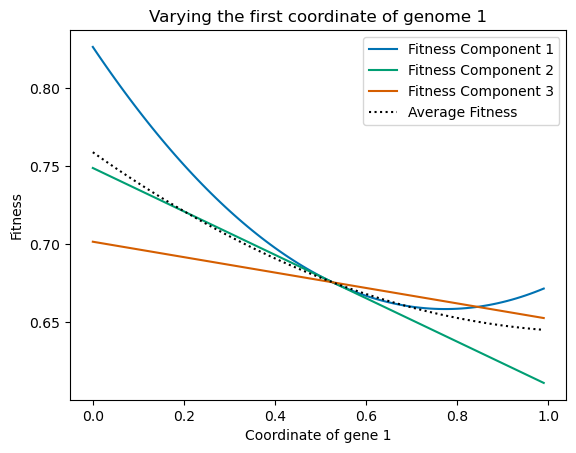

In [54]:
#Line for each fitness component and average fitness
for i in range(fit_var.shape[1]):
    plt.plot(np.array(range(len(fit_var))) / 100, fit_var[:, i], label=f'Fitness Component {i + 1}')

# Plot average fitness as a dotted line
plt.plot(np.array(range(len(fit_var))) / 100, avg_fit, color='k', linestyle='dotted', label='Average Fitness')

plt.xlabel('Coordinate of gene 1')
plt.ylabel('Fitness')
plt.title('Varying the first coordinate of genome 1')
plt.legend()
plt.show()



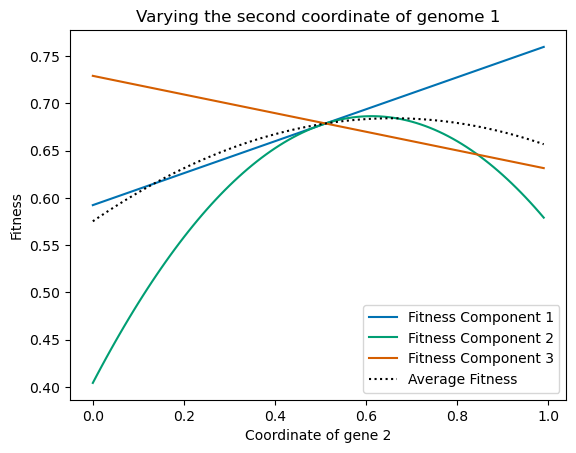

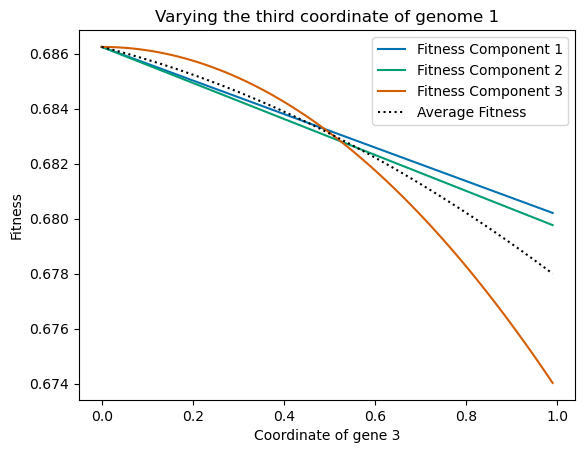

In [55]:
ind = 1 #pick specific group based on id 
varying_gene_vals2 = np.linspace(0, 1, 100)
constant_gene_vals2 = coords[ind-1, [0, 2]]

#create array for storing coordinates 
var_coords2 = np.zeros((100, 3))
# Replace first col of varying_coords with the values from the first array
var_coords2[:, 1] = varying_gene_vals2
var_coords2[:, [0, 2]] = np.tile(constant_gene_vals2, (100, 1))
fit_var2 = calculate_fitness_var(a_shape_rep, em_rep, var_coords2) #fitness components
avg_fit2 = np.mean(fit_var2, axis=1) #average fitness

varying_gene_vals3 = np.linspace(0, 1, 100)
constant_gene_vals3 = coords[ind-1, [0, 1]]

#create array for storing coordinates 
var_coords3 = np.zeros((100, 3))
# Replace first col of varying_coords with the values from the first array
var_coords3[:, 2] = varying_gene_vals
var_coords3[:, [0, 1]] = np.tile(constant_gene_vals3, (100, 1))
fit_var3 = calculate_fitness_var(a_shape_rep, em_rep, var_coords3) #fitness components
avg_fit3 = np.mean(fit_var3, axis=1) #average fitness

#plot
#Line for each fitness component and average fitness
for i in range(fit_var2.shape[1]):
    plt.plot(np.array(range(len(fit_var2))) / 100, fit_var2[:, i], label=f'Fitness Component {i + 1}')

# Plot average fitness as a dotted line
plt.plot(np.array(range(len(fit_var2))) / 100, avg_fit2, color='k', linestyle='dotted', label='Average Fitness')
plt.xlabel('Coordinate of gene 2')
plt.ylabel('Fitness')
plt.title('Varying the second coordinate of genome 1')
plt.legend()

plt.show()

#plot
#Line for each fitness component and average fitness
for i in range(fit_var3.shape[1]):
    plt.plot(np.array(range(len(fit_var3))) / 100, fit_var3[:, i], label=f'Fitness Component {i + 1}')

# Plot average fitness as a dotted line
plt.plot(np.array(range(len(fit_var3))) / 100, avg_fit3, color='k', linestyle='dotted', label='Average Fitness')
plt.xlabel('Coordinate of gene 3')
plt.ylabel('Fitness')
plt.title('Varying the third coordinate of genome 1')
plt.legend()
plt.show()


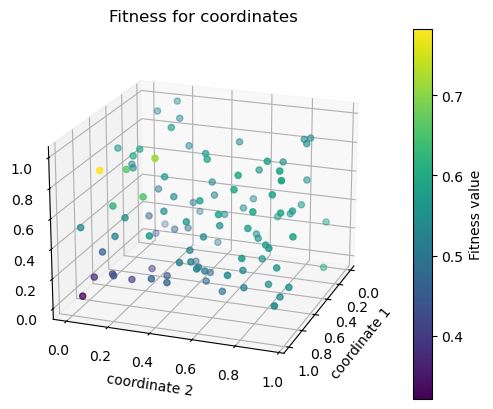

ValueError: Argument Z must be 2-dimensional.

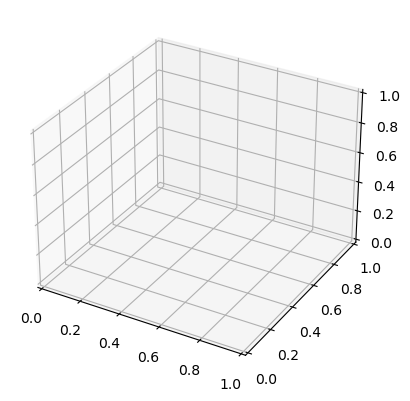

In [56]:
#now with random coordinates
rand_coords = np.random.rand(100, 3) #example
x1_values = rand_coords[:, 0]
x2_values = rand_coords[:, 1]
x3_values = rand_coords[:, 2]
y_values = calculate_fitness_var(a_shape, em, rand_coords)
fit_y = np.mean(y_values, axis=1,)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x1_values, x2_values, x3_values, c= fit_y, cmap='viridis', marker='o')

ax.set_xlabel('coordinate 1')
ax.set_ylabel('coordinate 2')
ax.set_zlabel('coordinate 3')
ax.set_title('Fitness for coordinates')
fig.colorbar(scatter, label='Fitness value')
ax.view_init(elev=20, azim=20) 

plt.show()

#next 2 coords & coloured y surface plot: fitness landscape
#varying x1 and x2, not x3. genome 1
varying_gene_vals = np.linspace(0, 1, 100)
var_coordsl = np.zeros((100, 3))
var_coordsl[:, 0] = varying_gene_vals
var_coordsl[:, 1] = varying_gene_vals
var_coordsl[:,2] = coords[0, [2]]
y_all = calculate_fitness_var(a_shape, em, var_coordsl)
y = np.mean(y_all, axis=1,) 
#(so have y per 3 coords)

#To be continued
# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Plot surface keeping x3 is constant
surface = ax.plot_surface(x, x2, y, cmap='viridis', rstride=1, cstride=1, alpha=0.8, antialiased=True)

ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
ax.set_title('Fitness varying first two coordinates')

# Add a color bar to show the mapping of values to colors
fig.colorbar(surface, ax=ax, shrink=0.5, aspect=10)

# Show the plot
plt.show()